In [1]:
import torch

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm

# View available fonts
# for font in fm.findSystemFonts(fontpaths = None, fontext = 'ttf'):
#    print(fm.FontProperties(fname = font).get_name())

# Set font properties
matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'Nimbus Roman'
matplotlib.rcParams['font.family'] = 'P052'

# Explore repulsion term

Sample two sets of x locations, one dense and one spread out.

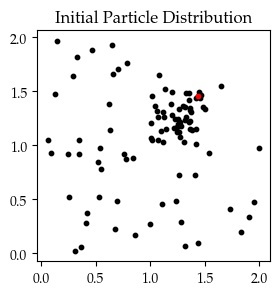

In [3]:
num_particles_each = 50

x_initial_spread = torch.rand(num_particles_each, 2) * 2 
x_initial_dense = torch.rand(num_particles_each, 2) / 2 + 1.0

# concat
x_initial = torch.cat([x_initial_spread, x_initial_dense], dim = 0)

# Selected index (from dense set)
i = -1

plt.figure(figsize = (3, 3))
plt.scatter(x_initial[:, 0], x_initial[:, 1], color = 'black', s = 10, label = 'Particles', alpha = 0.99)
plt.scatter(x_initial[i, 0], x_initial[i, 1], color = 'red', s = 10, label = 'Particles', alpha = 0.99)
plt.title('Initial Particle Distribution')
plt.show()

In [4]:
def median_heuristic(x):
    """
    Compute the median heuristic bandwidth for RBF kernel.
    
    Args:
        x (torch.Tensor): Tensor of shape [N, D]
    
    Returns:
        float: Bandwidth h
    """
    with torch.no_grad():
        # Compute pairwise squared distances
        x_norm = (x ** 2).sum(dim = 1).view(-1, 1)
        dists = x_norm + x_norm.T - 2 * x @ x.T

        # Get upper triangular (excluding diagonal) to avoid duplicates and zeros
        dists = dists[torch.triu(torch.ones_like(dists), diagonal = 1) == 1]

        # Return median of distances
        h = torch.median(dists)

        # h = torch.sqrt(h)

    return h.item()

In [7]:
# pairwise squared Euclidean distances
diff = x_initial[:, None, :] - x_initial[None, :, :] # shape: [N, N, D]
# squared (Euclidean) distance
sq_dist = (diff ** 2).sum(dim = -1) # shape: [N, N]

# Determine h via medium heuristic h = med^2 / log(n)
h = median_heuristic(x_initial)

K = torch.exp(- sq_dist / h)

grad_K = 2 / h * diff * K.unsqueeze(-1)
# Sum over axis 1 (over all other particles), to get the gradient of the kernel w.r.t. x_i
grad_K_summed = grad_K.sum(dim = 1)  # shape [N, D]

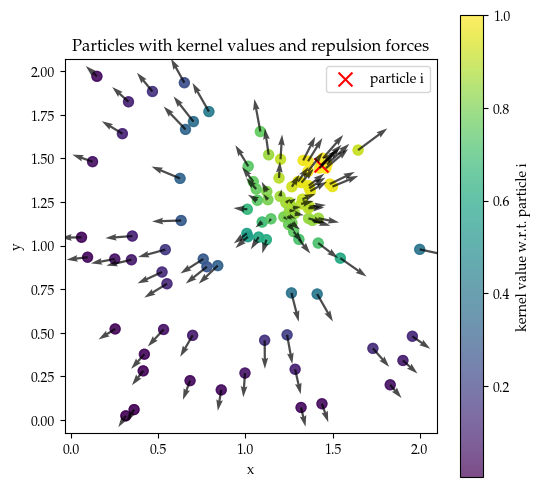

In [14]:
i = -1

# Normalize the K[i, :] values for color mapping
norm = plt.Normalize(vmin = K[i, :].min().item(), vmax = K[i, :].max().item())
cmap = plt.cm.viridis  # You can use any colormap here

# Plotting
plt.figure(figsize = (6, 6))

scatter = plt.scatter(x_initial[:, 0], x_initial[:, 1], c = K[i, :].detach().numpy(), cmap = cmap, s = 50, alpha = 0.7)

# Scatter plot: color particles according to kernel_out_selected
plt.scatter(x_initial[:, 0], x_initial[:, 1], c = K[i, :].detach().numpy(), cmap = cmap, s = 50, alpha = 0.7)

# Mark the last particle with a black cross
plt.scatter(x_initial[-1, 0], x_initial[-1, 1], color = 'red', s = 100, marker = 'x', label = 'particle i')

plt.quiver(
    x_initial[:, 0], x_initial[:, 1], grad_K_summed[:, 0], grad_K_summed[:, 1],
   angles = 'xy', scale_units = 'xy', color = 'black', alpha = 0.7
)

plt.quiver(
    x_initial[i, 0], x_initial[i, 1], grad_K_summed[i, 0], grad_K_summed[i, 1],
    angles = 'xy', scale_units = 'xy', color = 'black', alpha = 0.7
)

# Set labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable = 'box')
plt.title('Particles with kernel values and repulsion forces')
plt.colorbar(scatter, label = 'kernel value w.r.t. particle i')
plt.legend()

# Show the plot
plt.show()